In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

## Read the datset

In [14]:
train = pd.read_csv(r'C:\Users\vatsal\Desktop\DATASCIENCE\demand-forecasting-kernels-only\train.csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [16]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

In [17]:
print('Start: ', train['date'].min().date())
print('End: ', train['date'].max().date())

Start:  2013-01-01
End:  2017-12-31


In [18]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [19]:
train.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [20]:
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train = expand_df(train)
train.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5


## EDA

In [21]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [22]:
store_daily_sales.head()

,store,date,sales
0,1,2013-01-01,1316
1,1,2013-01-02,1264
2,1,2013-01-03,1305
3,1,2013-01-04,1452
4,1,2013-01-05,1499


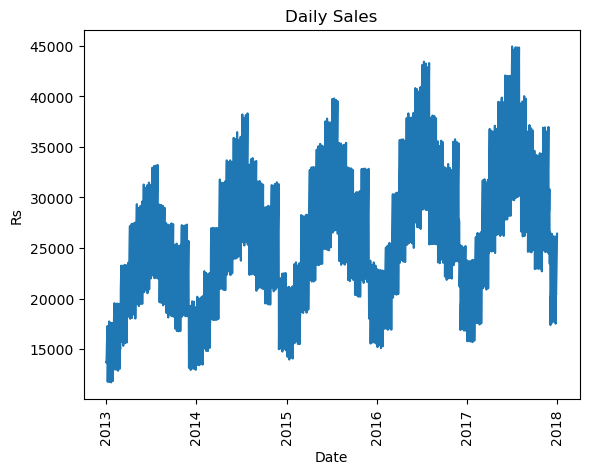

In [23]:
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.ylabel('Rs')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

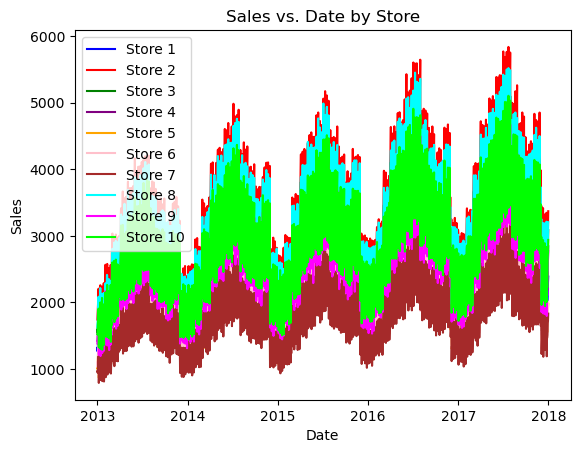

In [24]:
store_colors = {
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'pink',
    7: 'brown',
    8: 'cyan',
    9: 'magenta',
    10: 'lime'
}

fig, ax = plt.subplots()
for store, color in store_colors.items():
    store_data = store_daily_sales[store_daily_sales['store'] == store]
    ax.plot(store_data['date'], store_data['sales'], label=f'Store {store}', color=color)

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Store')
ax.legend()

# Show the plot
plt.show()

In [25]:
item_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
day_sales = train.groupby(['day', 'date'], as_index=False)['sales'].sum()
month_sales = train.groupby(['month', 'date'], as_index=False)['sales'].sum()
year_sales = train.groupby(['year', 'date'], as_index=False)['sales'].sum()
day_of_week_sales = train.groupby(['dayofweek', 'date'], as_index=False)['sales'].sum()

In [26]:
item_sales.head()

,item,date,sales
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149


Text(0.5, 1.0, 'Sales vs. Date by Item')

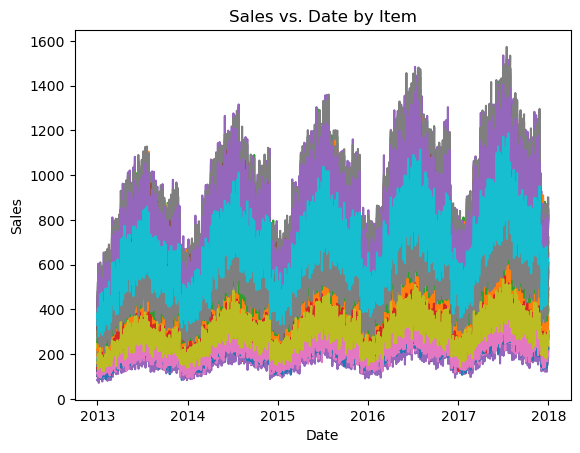

In [27]:
unique_items = item_sales['item'].unique()

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate through unique items and plot sales data for each item
for item in unique_items:
    item_data = item_sales[item_sales['item'] == item]
    ax.plot(item_data['date'], item_data['sales'], label=f'Item {item}')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Item')

<Figure size 640x480 with 0 Axes>

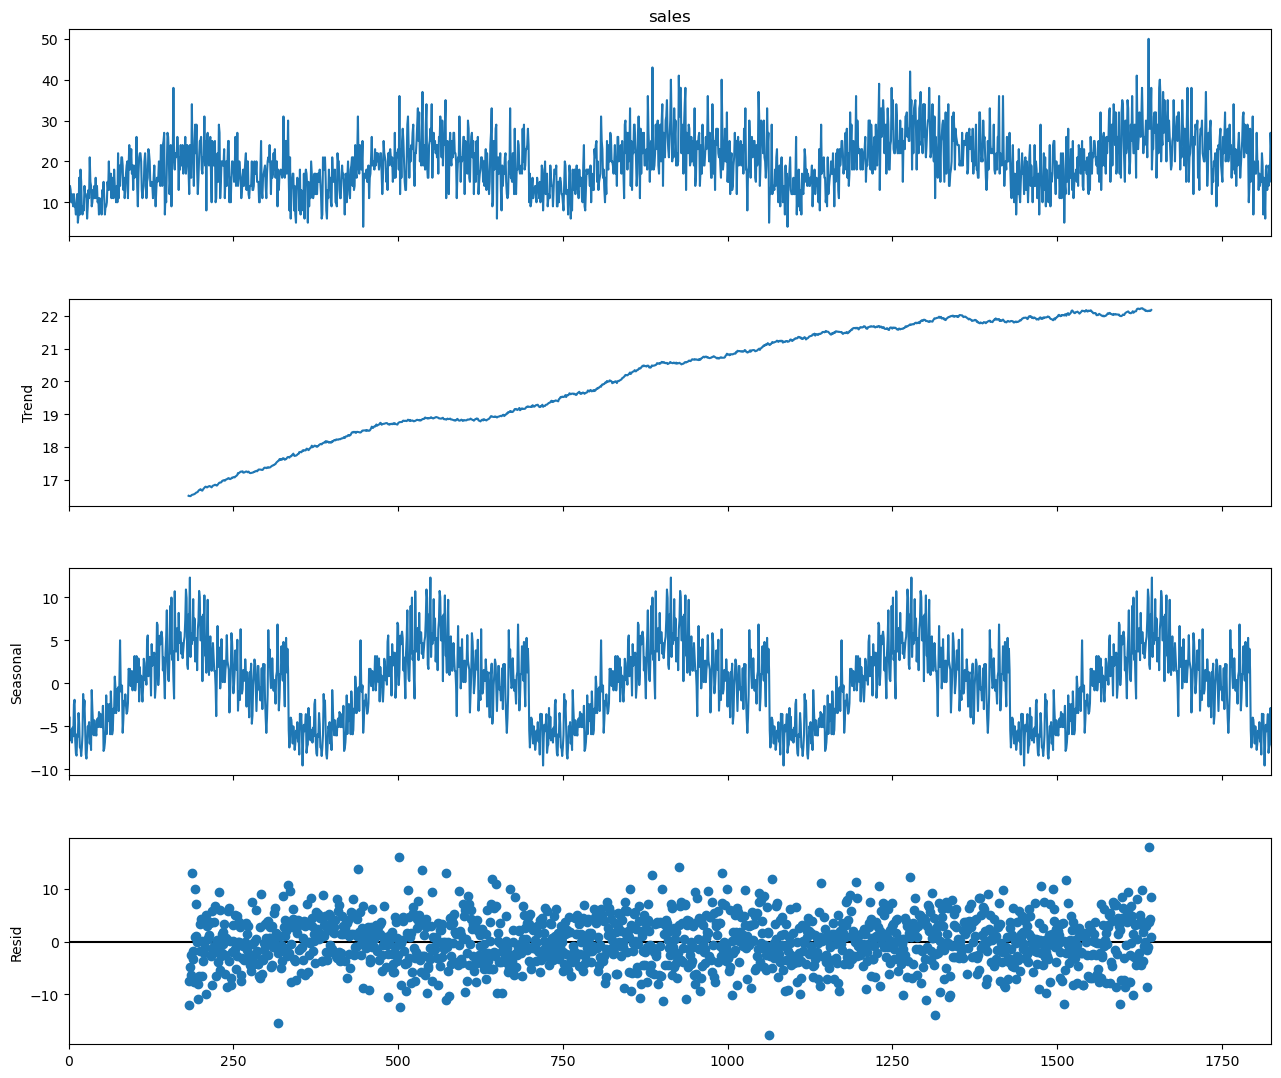

In [28]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train[train['item']==1]
train_final = train_item1[train_item1['store']==1]

#from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', period=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

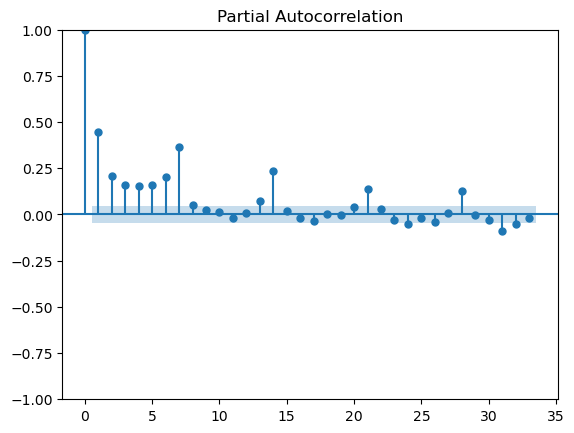

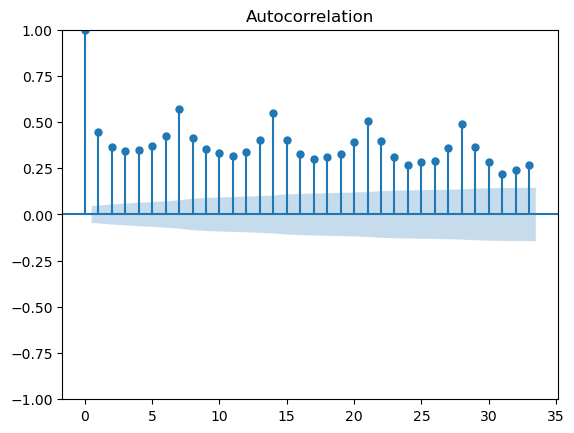

In [29]:
plot_pacf(train_final['sales']);
plot_acf(train_final['sales']);

In [30]:
ad_fuller_result = adfuller(train_final['sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.1576705563327994
p-value: 0.02256938062657181


The series is likely non-stationary.

In [31]:
first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())
print()

ad_fuller_result = adfuller(first_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

1   -2.0
2    3.0
3   -1.0
4   -3.0
5    2.0
Name: sales, dtype: float64

ADF Statistic: -12.676793886047514
p-value: 1.2109276320434391e-23


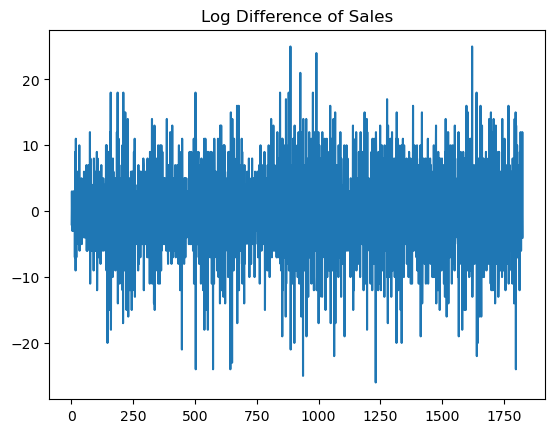

In [32]:
plt.plot(first_diff)
plt.title("Log Difference of Sales")
plt.show()

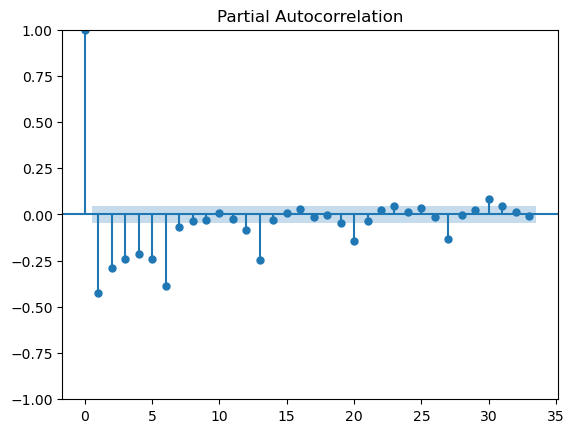

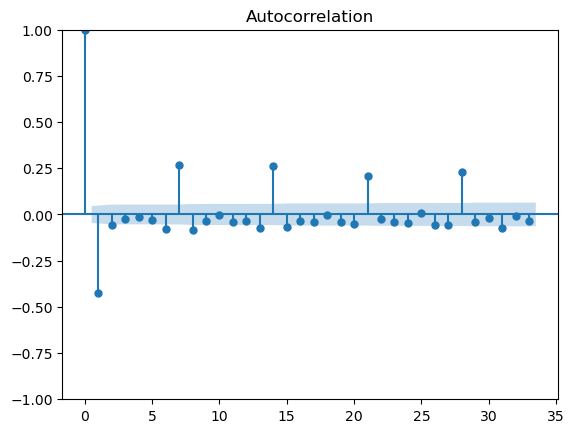

In [33]:
plot_pacf(first_diff);
plot_acf(first_diff);

## ARIMA

In [34]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [35]:
from itertools import product

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [36]:
result_df = optimize_ARIMA(train_final.sales, order_list)
result_df

,"(p, d, q)",AIC
0,"(6, 1, 7)",10905.658963
1,"(7, 1, 7)",10916.640017
2,"(5, 1, 5)",10998.821160
3,"(6, 1, 5)",11013.139548
4,"(4, 1, 7)",11027.995969
...,...,...
59,"(4, 1, 0)",11616.440522
60,"(3, 1, 0)",11701.431885
61,"(2, 1, 0)",11805.944671
62,"(1, 1, 0)",11963.116936


In [37]:
import statsmodels.api as sm
resDiff = sm.tsa.arma_order_select_ic(train_final.sales, max_ar=8, max_ma=8, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


In [38]:
arima_model = SARIMAX(train_final.sales, order=(6,1,7), simple_differencing=False)
res = arima_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -5438.829
Date:                Tue, 02 Apr 2024   AIC                          10905.659
Time:                        14:23:04   BIC                          10982.790
Sample:                             0   HQIC                         10934.111
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9780      0.013    -76.911      0.000      -1.003      -0.953
ar.L2         -0.9751      0.011    -92.621      0.000      -0.996      -0.954
ar.L3         -0.9778      0.010    -97.221      0.0

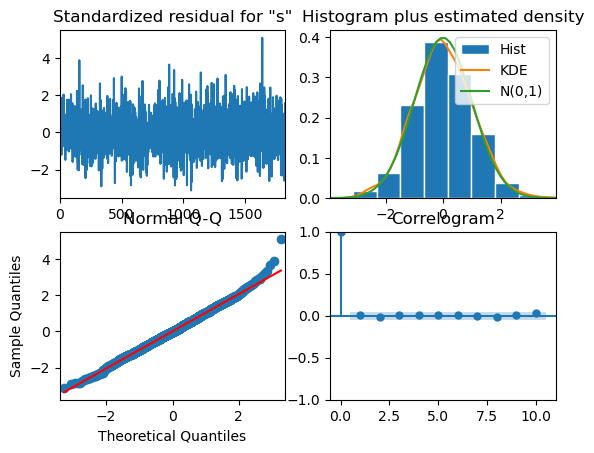

In [39]:
res.plot_diagnostics();

<Axes: >

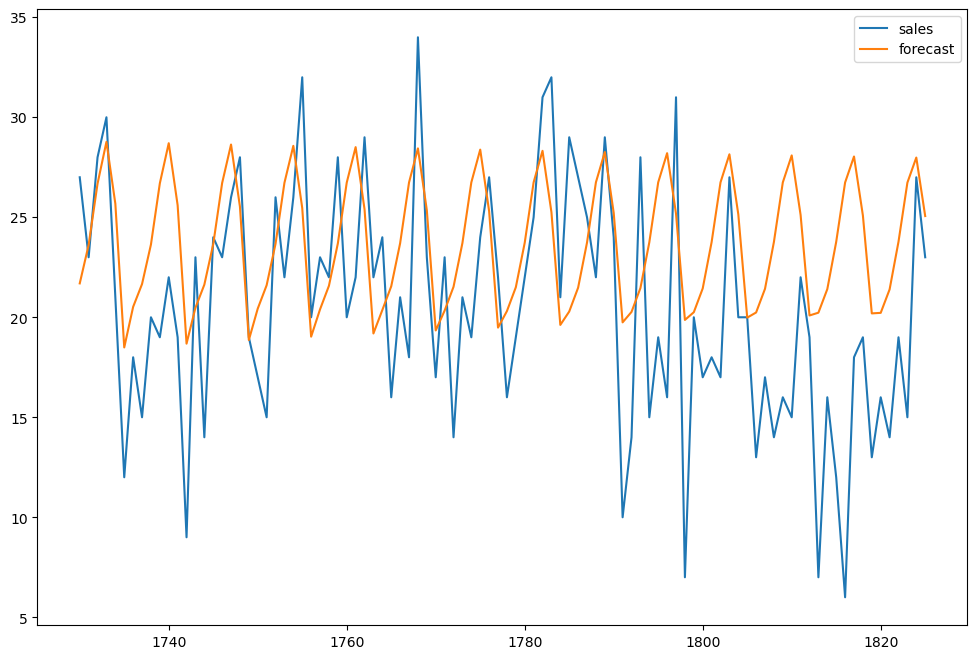

In [40]:
start_index = 1730
end_index = 1826
train['forecast'] = res.predict(start = start_index, end= end_index, dynamic= True)  
train[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

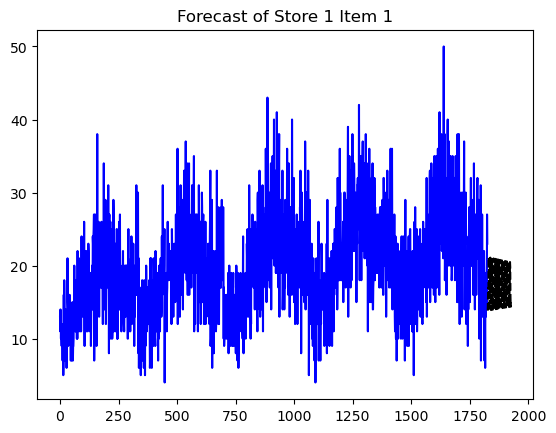

In [41]:
n_forecast =100
predict = res.get_prediction(end=arima_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(train_final.sales, 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

In [42]:
train_final['model'] = predict.predicted_mean
train_final.head(15)

,date,store,item,sales,day,month,year,dayofweek,model
0,2013-01-01,1,1,13,1,1,2013,1,0.000000
1,2013-01-02,1,1,11,2,1,2013,2,12.999750
2,2013-01-03,1,1,14,3,1,2013,3,11.868349
3,2013-01-04,1,1,13,4,1,2013,4,12.884985
4,2013-01-05,1,1,10,5,1,2013,5,12.888132
5,2013-01-06,1,1,12,6,1,2013,6,11.820983
6,2013-01-07,1,1,10,7,1,2013,0,12.113105
7,2013-01-08,1,1,9,8,1,2013,1,11.984343
8,2013-01-09,1,1,12,9,1,2013,2,11.396091
9,2013-01-10,1,1,9,10,1,2013,3,12.283962


In [43]:
mse = mean_squared_error(train_final['sales'], train_final['model'])
print(f'MSE: {mse}')

MSE: 22.692358295773058


## SARIMA

In [47]:
len(train_final.sales)

1826

In [ ]:
best_model = SARIMAX(train_final.sales, order=(6,1,7), seasonal_order=(6,1,7,12), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

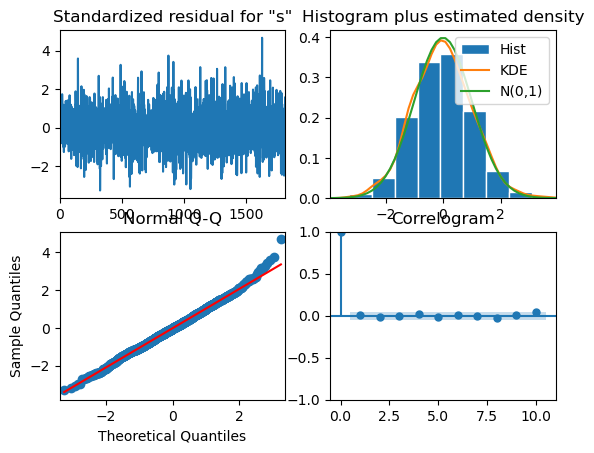

In [48]:
res.plot_diagnostics();

<Axes: >

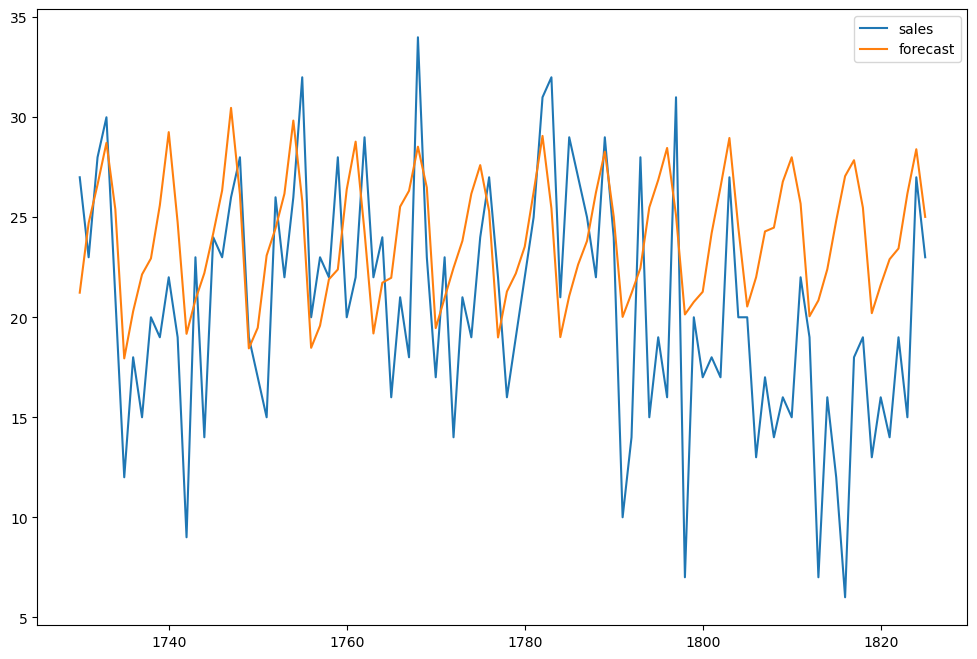

In [49]:
start_index = 1730
end_index = 1826
train['forecast'] = res.predict(start = start_index, end= end_index, dynamic= True)  
train[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

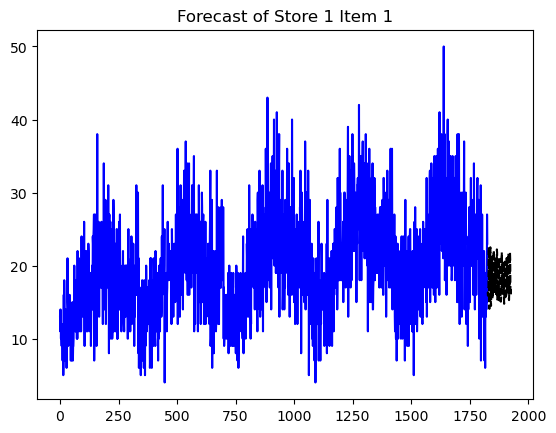

In [50]:
n_forecast =100
predict = res.get_prediction(end=arima_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(train_final.sales, 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

In [51]:
train_final['model'] = predict.predicted_mean
train_final.head(15)

,date,store,item,sales,day,month,year,dayofweek,model
0,2013-01-01,1,1,13,1,1,2013,1,0.000000
1,2013-01-02,1,1,11,2,1,2013,2,12.999753
2,2013-01-03,1,1,14,3,1,2013,3,11.000029
3,2013-01-04,1,1,13,4,1,2013,4,13.999907
4,2013-01-05,1,1,10,5,1,2013,5,13.000013
5,2013-01-06,1,1,12,6,1,2013,6,10.000092
6,2013-01-07,1,1,10,7,1,2013,0,11.999938
7,2013-01-08,1,1,9,8,1,2013,1,10.000147
8,2013-01-09,1,1,12,9,1,2013,2,9.000017
9,2013-01-10,1,1,9,10,1,2013,3,11.999911


In [52]:
mse = mean_squared_error(train_final['sales'], train_final['model'])
print(f'MSE: {mse}')

MSE: 23.449087190698656


SARIMA also kind of same results ==> go for SARIMAX or ARIMAX where we consider exogenous variables also

## ARIMAX

In [53]:
buf = train[(train.item==1)&(train.store==1)].copy()

In [54]:
buf.head()

,date,store,item,sales,day,month,year,dayofweek,forecast
0,2013-01-01,1,1,13,1,1,2013,1,NaN
1,2013-01-02,1,1,11,2,1,2013,2,NaN
2,2013-01-03,1,1,14,3,1,2013,3,NaN
3,2013-01-04,1,1,13,4,1,2013,4,NaN
4,2013-01-05,1,1,10,5,1,2013,5,NaN


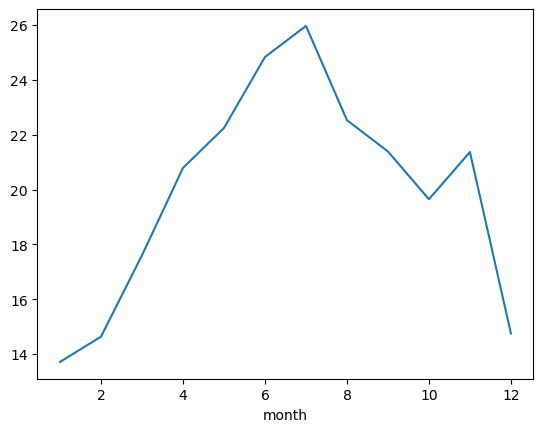

In [55]:
buf.groupby(buf.month).sales.mean().plot();plt.show()

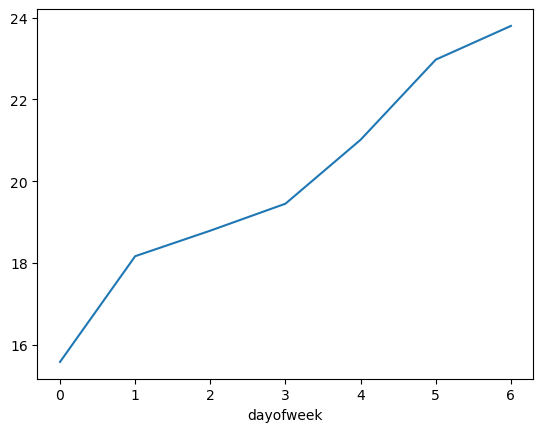

In [56]:
buf.groupby(buf.dayofweek).sales.mean().plot();plt.show()

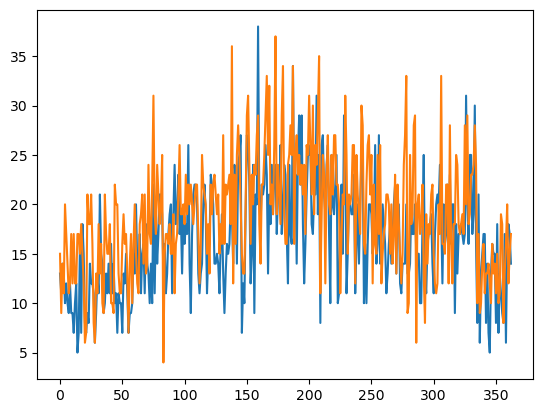

In [57]:
plt.plot(buf[0:363].sales.dropna().values)
plt.plot(buf[364:727].sales.dropna().values);plt.show()

In [58]:
buf.head()

,date,store,item,sales,day,month,year,dayofweek,forecast
0,2013-01-01,1,1,13,1,1,2013,1,NaN
1,2013-01-02,1,1,11,2,1,2013,2,NaN
2,2013-01-03,1,1,14,3,1,2013,3,NaN
3,2013-01-04,1,1,13,4,1,2013,4,NaN
4,2013-01-05,1,1,10,5,1,2013,5,NaN


In [59]:
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]

In [60]:
month_dummies.head()

,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,True,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False


In [61]:
buf = pd.concat([buf, month_dummies], axis=1).drop(['month','forecast'],axis=1)

In [62]:
buf.head()

,date,store,item,sales,day,year,dayofweek,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,2013-01-01,1,1,13,1,2013,1,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,1,1,11,2,2013,2,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,1,1,14,3,2013,3,True,False,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,1,1,13,4,2013,4,True,False,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,1,1,10,5,2013,5,True,False,False,False,False,False,False,False,False,False,False,False


In [63]:
buf.columns

Index(['date', 'store', 'item', 'sales', 'day', 'year', 'dayofweek', 'month-1',
       'month-2', 'month-3', 'month-4', 'month-5', 'month-6', 'month-7',
       'month-8', 'month-9', 'month-10', 'month-11', 'month-12'],
      dtype='object')

In [64]:
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1)
#Satday,Sunday
buf['weekend'] = (buf.dayofweek>4).astype(int)
buf = buf.drop(['dayofweek'],axis=1)

In [65]:
buf.head()

,date,store,item,sales,day,year,month-1,month-2,month-3,month-4,...,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend
0,2013-01-01,1,1,13,1,2013,True,False,False,False,...,False,False,False,True,False,False,False,False,False,0
1,2013-01-02,1,1,11,2,2013,True,False,False,False,...,False,False,False,False,True,False,False,False,False,0
2,2013-01-03,1,1,14,3,2013,True,False,False,False,...,False,False,False,False,False,True,False,False,False,0
3,2013-01-04,1,1,13,4,2013,True,False,False,False,...,False,False,False,False,False,False,True,False,False,0
4,2013-01-05,1,1,10,5,2013,True,False,False,False,...,False,False,False,False,False,False,False,True,False,1


In [66]:
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)

In [67]:
buf.head()

,date,store,item,sales,day,year,month-1,month-2,month-3,month-4,...,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sales_shifted_728,sales_shifted_364
0,2013-01-01,1,1,13,1,2013,True,False,False,False,...,False,True,False,False,False,False,False,0,NaN,NaN
1,2013-01-02,1,1,11,2,2013,True,False,False,False,...,False,False,True,False,False,False,False,0,NaN,NaN
2,2013-01-03,1,1,14,3,2013,True,False,False,False,...,False,False,False,True,False,False,False,0,NaN,NaN
3,2013-01-04,1,1,13,4,2013,True,False,False,False,...,False,False,False,False,True,False,False,0,NaN,NaN
4,2013-01-05,1,1,10,5,2013,True,False,False,False,...,False,False,False,False,False,True,False,1,NaN,NaN


In [68]:
buf.index = buf['date']

In [69]:
buf.head()

,date,store,item,sales,day,year,month-1,month-2,month-3,month-4,...,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sales_shifted_728,sales_shifted_364
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013-01-01,1,1,13,1,2013,True,False,False,False,...,False,True,False,False,False,False,False,0,NaN,NaN
2013-01-02,2013-01-02,1,1,11,2,2013,True,False,False,False,...,False,False,True,False,False,False,False,0,NaN,NaN
2013-01-03,2013-01-03,1,1,14,3,2013,True,False,False,False,...,False,False,False,True,False,False,False,0,NaN,NaN
2013-01-04,2013-01-04,1,1,13,4,2013,True,False,False,False,...,False,False,False,False,True,False,False,0,NaN,NaN
2013-01-05,2013-01-05,1,1,10,5,2013,True,False,False,False,...,False,False,False,False,False,True,False,1,NaN,NaN


In [70]:
buf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1826 non-null   datetime64[ns]
 1   store              1826 non-null   int64         
 2   item               1826 non-null   int64         
 3   sales              1826 non-null   int64         
 4   day                1826 non-null   int32         
 5   year               1826 non-null   int32         
 6   month-1            1826 non-null   bool          
 7   month-2            1826 non-null   bool          
 8   month-3            1826 non-null   bool          
 9   month-4            1826 non-null   bool          
 10  month-5            1826 non-null   bool          
 11  month-6            1826 non-null   bool          
 12  month-7            1826 non-null   bool          
 13  month-8            1826 non-null   bool      

In [71]:
tr_end = '2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'

tra = buf['sales'][:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

exog_train = buf.drop(['date','store','item','sales'],axis = 1)[:tr_end]
exog_test = buf.drop(['date', 'store','item','sales'],axis = 1)[te_start:te_end]

In [72]:
exog_train.shape

(1734, 24)

In [73]:
tra

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-09-26    18
2017-09-27    27
2017-09-28    23
2017-09-29    28
2017-09-30    30
Name: sales, Length: 1734, dtype: int64

In [74]:
exog_train = exog_train.reindex(tra.index).fillna(0)
exog_test = exog_test.reindex(tes.index).fillna(0)

In [75]:
exog_train = exog_train.fillna(0)

In [76]:
print(tra.dtypes)
print(exog_train.dtypes)


int64
day                    int32
year                   int32
month-1                 bool
month-2                 bool
month-3                 bool
month-4                 bool
month-5                 bool
month-6                 bool
month-7                 bool
month-8                 bool
month-9                 bool
month-10                bool
month-11                bool
month-12                bool
dayofweek-0             bool
dayofweek-1             bool
dayofweek-2             bool
dayofweek-3             bool
dayofweek-4             bool
dayofweek-5             bool
dayofweek-6             bool
weekend                int32
sales_shifted_728    float64
sales_shifted_364    float64
dtype: object


In [77]:
exog_train = exog_train.astype(int)


In [78]:
best_model = SARIMAX(tra, order=(6,1,7), seasonal_order=(0,0,0,0), exog = exog_train,freq='D',enforce_stationarity=False, enforce_invertibility=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -5017.233
Date:                Tue, 02 Apr 2024   AIC                          10110.465
Time:                        14:41:01   BIC                          10317.679
Sample:                    01-01-2013   HQIC                         10187.120
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
day                   0.0129      0.012      1.061      0.289      -0.011       0.037
year                  0.5393      1.317      0.409      0.682      -2.042       3.121
month-1              -6.

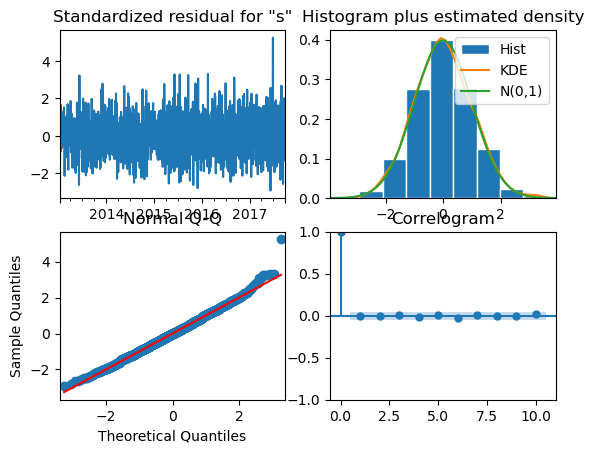

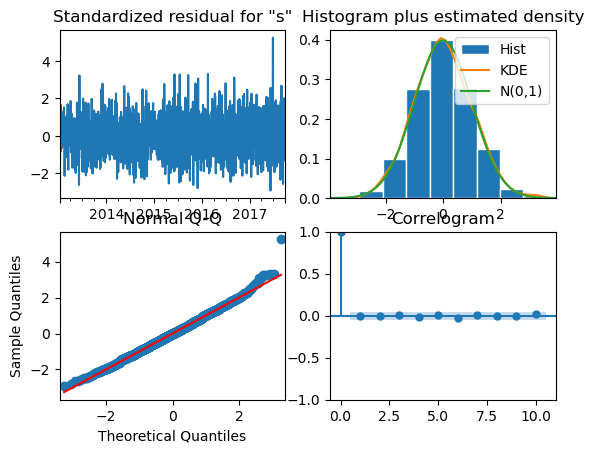

In [79]:
res.plot_diagnostics()

In [80]:
exog_test = exog_test.astype(int)  # Convert to float or appropriate numeric type

In [81]:
from sklearn.metrics import mean_squared_error
pred = res.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMAX model MSE:22.9470610931602


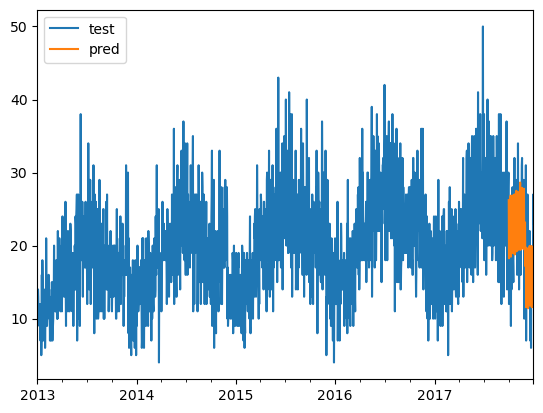

In [82]:
pd.DataFrame({'test':buf['sales'],'pred':pred}).plot();plt.show()

## Predictions

In [84]:
train = pd.read_csv(r'C:\Users\vatsal\Desktop\DATASCIENCE\demand-forecasting-kernels-only\train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv(r'C:\Users\vatsal\Desktop\DATASCIENCE\demand-forecasting-kernels-only\test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv(r'C:\Users\vatsal\Desktop\DATASCIENCE\demand-forecasting-kernels-only\sample_submission.csv')

In [85]:
df['month'] = df.index.month
month_dummies = pd.get_dummies(df['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df = pd.concat([df, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
df['dayofweek'] = df.index.weekday
week_dummies = pd.get_dummies(df['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df = pd.concat([df, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
df['weekend'] = (df.index.dayofweek>4).astype(int)#Satday,Sunday

#shifts
shifts = [364,728]
for s in shifts:
    df['store_item_shifted-'+str(s)] = df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(s))

# Checking for one Store and one item

In [86]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,2):
    for s in range(1,2):
        buf = df[(df.item==i)&(df.store==s)].copy()
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        exog_train = exog_train.astype(int)
        #fitting
        mod = SARIMAX(tra,order=(6,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        
        target_exog = target_exog.astype(int) 
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.


In [87]:
p = test[(test.item==1)&(test.store==1)].copy()

In [88]:
p['prediction'] = results

In [89]:
temp = train[(train.item==1)&(train.store==1)].copy()

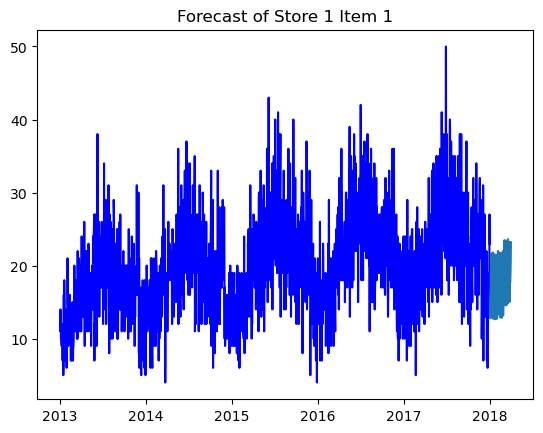

In [90]:
fig, ax = plt.subplots()
ax.plot(temp.sales, 'blue')
ax.plot(p.prediction)

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

# Looping through all

In [91]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,51):
    for s in range(1,11):
        buf = df[(df.item==i)&(df.store==s)].copy()
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        exog_train = exog_train.astype(int)
        #fitting
        mod = SARIMAX(tra,order=(6,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        
        target_exog = target_exog.astype(int) 
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.
item: 1 store: 2 Finished.
item: 1 store: 3 Finished.
item: 1 store: 4 Finished.
item: 1 store: 5 Finished.
item: 1 store: 6 Finished.
item: 1 store: 7 Finished.
item: 1 store: 8 Finished.
item: 1 store: 9 Finished.
item: 1 store: 10 Finished.
item: 2 store: 1 Finished.
item: 2 store: 2 Finished.
item: 2 store: 3 Finished.
item: 2 store: 4 Finished.
item: 2 store: 5 Finished.
item: 2 store: 6 Finished.
item: 2 store: 7 Finished.
item: 2 store: 8 Finished.
item: 2 store: 9 Finished.
item: 2 store: 10 Finished.
item: 3 store: 1 Finished.
item: 3 store: 2 Finished.
item: 3 store: 3 Finished.
item: 3 store: 4 Finished.
item: 3 store: 5 Finished.
item: 3 store: 6 Finished.
item: 3 store: 7 Finished.
item: 3 store: 8 Finished.
item: 3 store: 9 Finished.
item: 3 store: 10 Finished.
item: 4 store: 1 Finished.
item: 4 store: 2 Finished.
item: 4 store: 3 Finished.
item: 4 store: 4 Finished.
item: 4 store: 5 Finished.
item: 4 store: 6 Finished.
item: 4 store: 7 Finished

item: 30 store: 6 Finished.
item: 30 store: 7 Finished.
item: 30 store: 8 Finished.
item: 30 store: 9 Finished.
item: 30 store: 10 Finished.
item: 31 store: 1 Finished.
item: 31 store: 2 Finished.
item: 31 store: 3 Finished.
item: 31 store: 4 Finished.
item: 31 store: 5 Finished.
item: 31 store: 6 Finished.
item: 31 store: 7 Finished.
item: 31 store: 8 Finished.
item: 31 store: 9 Finished.
item: 31 store: 10 Finished.
item: 32 store: 1 Finished.
item: 32 store: 2 Finished.
item: 32 store: 3 Finished.
item: 32 store: 4 Finished.
item: 32 store: 5 Finished.
item: 32 store: 6 Finished.
item: 32 store: 7 Finished.
item: 32 store: 8 Finished.
item: 32 store: 9 Finished.
item: 32 store: 10 Finished.
item: 33 store: 1 Finished.
item: 33 store: 2 Finished.
item: 33 store: 3 Finished.
item: 33 store: 4 Finished.
item: 33 store: 5 Finished.
item: 33 store: 6 Finished.
item: 33 store: 7 Finished.
item: 33 store: 8 Finished.
item: 33 store: 9 Finished.
item: 33 store: 10 Finished.
item: 34 store: 

In [93]:
sample['sales'] = results
sample.to_csv('submission.csv',index=False)